In [2]:
#Import libraries
import sys
sys.path.append('..')
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from utils.functions import plot_predictive
from utils.layers import BatchLinear



## Organize Toy Dataset

In [3]:
def features(x):
    return np.hstack([x[:, None] / 2.0, (x[:, None] / 2.0) ** 2])

In [4]:
# Load toy dataset
data = np.load(r"..\data\toy_data.npy")
#data = data[1:] # Remove an outlier
x, y = data[:, 0], data[:, 1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform x with two features -> 2 column tensor
f = features(x)

dataset = torch.utils.data.TensorDataset(torch.from_numpy(f.astype(np.float32)).to(device), 
                                         torch.from_numpy(y.astype(np.float32)).reshape(-1, 1).to(device))

In [5]:
BATCH_SIZE = 32


# Initialize the dataloaders
dataloader = DataLoader(dataset=dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)


# Check what we've created
print(f"DataLoader: {dataloader}" )
print(f"Length of train_dataloader: {len(dataloader)} batches of {BATCH_SIZE}...")

# Input to the model is (samples/batch size) x batch size
print(f"#Training datasamples/Batch Size: {len(data)}/{BATCH_SIZE}= {len(data)/BATCH_SIZE}")

DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x000001D811A38ED0>
Length of train_dataloader: 13 batches of 32...
#Training datasamples/Batch Size: 400/32= 12.5


## Create a Base NN

In [25]:
class BaseNN(nn.Module):
        def __init__(self,
                     input_shape:int, 
                     hidden_units: int, 
                     output_shape: int):
            super().__init__()
            self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=1),
        )
        def forward(self, x):
            return self.layer_stack(x)

# Create first deep ensemble
Our first Deep Ensemble will act as a baseline model to compare with. It has a very "Naive" approach.  
We train each ensemble member for 10 epochs with a simple NN archtiecture (BaseNN), we do not inject any noise or prior belief into our model.

In [53]:
M = 5 # Number of ensemble members

# Initiate models
NaiveEnsemble = [BaseNN(input_shape=2,hidden_units=128,output_shape=1) for i in range(M)]

In [71]:
# Training Parameters
EPOCHS = 300
# Train each ensemble member
for model in NaiveEnsemble:
    # Initiate Loss function and Optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr= 0.02, weight_decay=0.)
    model.to(device)
    # Conduct training
    for epoch in range(EPOCHS):
        # Training
        train_loss = 0
        # Add a loop to loop through the training batches
        for batch, (X, y) in enumerate(dataloader):
            model.train()
            # 1. Perform forward pass
            y_pred = model(X) # Make prediction

            # 2. Calculate loss per batch
            loss = loss_function(y_pred.squeeze(), y) # Calculate loss with MSE

            train_loss += loss.item() # Accumalate loss

            # 3. Optimizer zero grad
            optimizer.zero_grad() # Set the optimizer's gradients to zero

            # 4. Loss backward
            loss.backward()

            #5. Optimizer step
            optimizer.step()
        if epoch%50 == 0:
            print(f"Epoch: {epoch}\n-------")
            print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch
        
    

Epoch: 0
-------
Loss: 0.08365364243777898
Epoch: 50
-------
Loss: 0.0032902536555551565
Epoch: 100
-------
Loss: 0.0031672639306634665
Epoch: 150
-------
Loss: 0.003195570817647072
Epoch: 200
-------
Loss: 0.0031589339666355113
Epoch: 250
-------
Loss: 0.0031175611433214867
Epoch: 0
-------
Loss: 0.0718928685841652
Epoch: 50
-------
Loss: 0.003127665402224431
Epoch: 100
-------
Loss: 0.0030981105788109396
Epoch: 150
-------
Loss: 0.003057424176054505
Epoch: 200
-------
Loss: 0.0029931107464318094
Epoch: 250
-------
Loss: 0.002929196836283574
Epoch: 0
-------
Loss: 0.07674213599127072
Epoch: 50
-------
Loss: 0.0032971179148612115
Epoch: 100
-------
Loss: 0.0033096895875552525
Epoch: 150
-------
Loss: 0.00318979976985317
Epoch: 200
-------
Loss: 0.003137210849672556
Epoch: 250
-------
Loss: 0.0030797764014166137
Epoch: 0
-------
Loss: 0.07749493391467975
Epoch: 50
-------
Loss: 0.003038960652282605
Epoch: 100
-------
Loss: 0.003262457043792193
Epoch: 150
-------
Loss: 0.0031024526912145

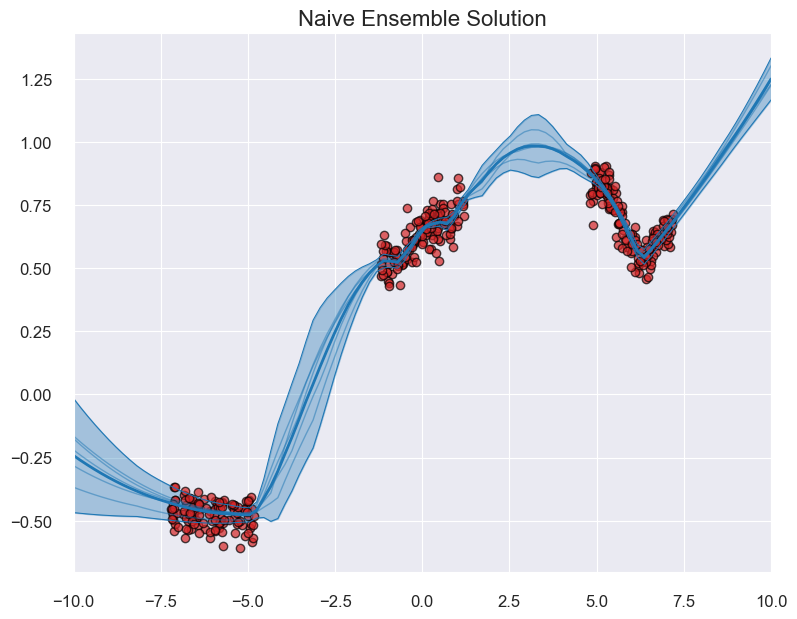

In [73]:
# Plot code from drbayes github
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32)).to(device)

trajectories = []
for model in NaiveEnsemble:
    out = model(inp).cpu().detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="Naive Ensemble Solution")

## Anchored Ensemble
In this version of Deep Ensemble we will try incorporate the Random MAP Samling approach as proposed in the Anchored Ensemble paper.

### Some math notation for Anchored Ensemble
$Loss_j = \dfrac{1}{N}GaussianNLL(y,\hat{y}_j) + \dfrac{1}{N}||\tau^{1/2}\cdot(\theta_j- \theta_{anc,j})||_2^2 $  
where $diag(\tau)_i = \sigma_{\epsilon}^2/\sigma_{prior_i}^2$  
and we draw $\theta_{anc} \sim \mathcal{N}(\mu_{prior}, \Sigma_{prior})$

In [38]:
# Let us initiate our hyperparameters
data_noise = 0.2
mu_prior = 0
# First layer prior variance
Sigma_prior_0 = 2
# Second layer prior variance
Sigma_prior_1 =  5

# Calculate tau
tau_0 = data_noise/Sigma_prior_0
tau_1 = data_noise/Sigma_prior_1

In [39]:
M = 5 # Number of ensemble members
n_hidden = 128 # Hidden units in NN
# Initiate models
AnchoredEnsemble = [BaseNN(input_shape=2,hidden_units=n_hidden,output_shape=1) for i in range(M)]

In [40]:
# Training Parameters
EPOCHS = 300
# Train each ensemble member
for model in AnchoredEnsemble:
    # Initiate Loss function and Optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr= 0.001)

    # Draw anchoring points (Randomly different for each NN)
    # Anchored theta first layer
    theta_anc_0 = np.random.normal(loc=mu_prior, scale=np.sqrt(Sigma_prior_0), size=[n_hidden,2])
    # Anchored theta last layer
    theta_anc_1 = np.random.normal(loc=mu_prior,scale=np.sqrt(Sigma_prior_1), size=[1,n_hidden])

    #Convert to torch tensors
    theta_anc_0 = torch.tensor(theta_anc_0).float().to(device)
    theta_anc_1 = torch.tensor(theta_anc_1).float().to(device)
    # Conduct training
    for epoch in range(EPOCHS):
        # Training
        train_loss = 0
        reg_term = 0
        model.to(device)
        # Add a loop to loop through the training batches
        for batch, (X, y) in enumerate(dataloader):
            model.train()
            # 1. Perform forward pass
            y_pred = model(X) # Make prediction

            # 2. Calculate loss per batch
            loss = loss_function(y_pred, y) # Calculate loss with GausianNLLoss

            # Calculate regularization
            reg_term += tau_0*torch.mul(model.layer_stack[0].weight-theta_anc_0,model.layer_stack[0].weight-theta_anc_0).sum()
            reg_term += tau_1*torch.mul(model.layer_stack[2].weight-theta_anc_1,model.layer_stack[2].weight-theta_anc_1).sum()

            #Accumlate loss
            train_loss += loss.item() + reg_term.item()
            
            # 3. Optimizer zero grad
            optimizer.zero_grad() # Set the optimizer's gradients to zero

            # 4. Loss backward
            loss.backward()

            #5. Optimizer step
            optimizer.step()
        
        if epoch%50 == 0:
            print(f"Epoch: {epoch}\n-------")
            print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch

Epoch: 0
-------
Loss: 529.2308562810605
Epoch: 50
-------
Loss: 528.2396769959552
Epoch: 100
-------
Loss: 528.5729084805263
Epoch: 150
-------
Loss: 529.1604856684303
Epoch: 200
-------
Loss: 529.5626597473791
Epoch: 250
-------
Loss: 529.6962463009672
Epoch: 0
-------
Loss: 489.9650542632892
Epoch: 50
-------
Loss: 489.9676078016906
Epoch: 100
-------
Loss: 490.9881531392188
Epoch: 150
-------
Loss: 491.3155373208082
Epoch: 200
-------
Loss: 491.29812174100573
Epoch: 250
-------
Loss: 491.1741848976101
Epoch: 0
-------
Loss: 581.9358899799677
Epoch: 50
-------
Loss: 579.3035453825007
Epoch: 100
-------
Loss: 578.5024999055313
Epoch: 150
-------
Loss: 577.9140963164301
Epoch: 200
-------
Loss: 577.6549614136501
Epoch: 250
-------
Loss: 577.1891100139608
Epoch: 0
-------
Loss: 597.8074279599465
Epoch: 50
-------
Loss: 594.4988279151372
Epoch: 100
-------
Loss: 594.0663840784512
Epoch: 150
-------
Loss: 594.0207940260163
Epoch: 200
-------
Loss: 594.1987291005387
Epoch: 250
-------
Los

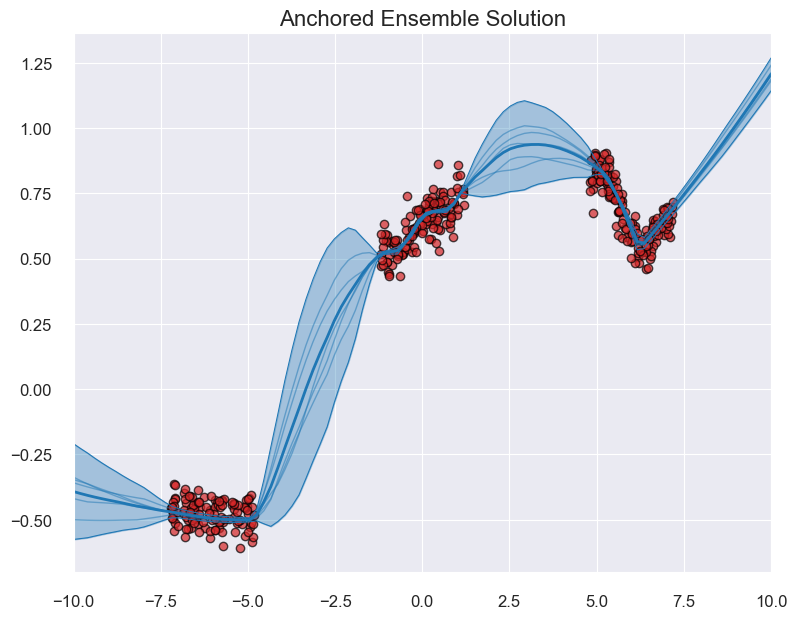

In [37]:
# Plot code from drbayes github
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32)).to(device)

trajectories = []
for model in AnchoredEnsemble:
    out = model(inp).cpu().detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="Anchored Ensemble Solution")

## BatchEnsemble

In [6]:
class BaseBatchEnsemble(nn.Module):
        def __init__(self,
                     ensemble_size:int,
                     input_shape:int, 
                     hidden_units: int, 
                     output_shape: int,
                     ):
            super().__init__()
            self.layer_stack = nn.Sequential(
            BatchLinear(ensemble_size=ensemble_size,
                        in_features=input_shape,
                        out_features=hidden_units),
            nn.ReLU(),
            BatchLinear(ensemble_size=ensemble_size,
                      in_features=hidden_units,
                      out_features=1),
        )
        def forward(self, x):
            return self.layer_stack(x)

In [7]:
# Creata a Model
M = 5 # Ensemble size
h_units = 128 # Hidden units

ShallowBatchEnsemble = BaseBatchEnsemble(ensemble_size=M,input_shape=2,hidden_units=h_units,output_shape=1)

In [8]:
# Training Parameters
EPOCHS = 300
# Initiate Loss function and Optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(ShallowBatchEnsemble.parameters(), lr= 0.02, weight_decay=0.)
ShallowBatchEnsemble.to(device)
# Conduct training
for epoch in range(EPOCHS):
    # Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(dataloader):
        ShallowBatchEnsemble.train()
        # 1. Perform forward pass
        y_pred = ShallowBatchEnsemble(X.repeat(M,1)) # Make prediction

        # 2. Calculate loss per batch
        loss = loss_function(y_pred, y.repeat(M,1)) # Calculate loss with MSE

        train_loss += loss.item() # Accumalate loss

        # 3. Optimizer zero grad
        optimizer.zero_grad() # Set the optimizer's gradients to zero

        # 4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()
    if epoch%50 == 0:
        print(f"Epoch: {epoch}\n-------")
        print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch
        
    

Epoch: 0
-------
Loss: 0.26250565166656786
Epoch: 50
-------
Loss: 0.003690147987351968
Epoch: 100
-------
Loss: 0.0033373046988764633
Epoch: 150
-------
Loss: 0.003428227357709637
Epoch: 200
-------
Loss: 0.0032279533692277395
Epoch: 250
-------
Loss: 0.003321375662031082


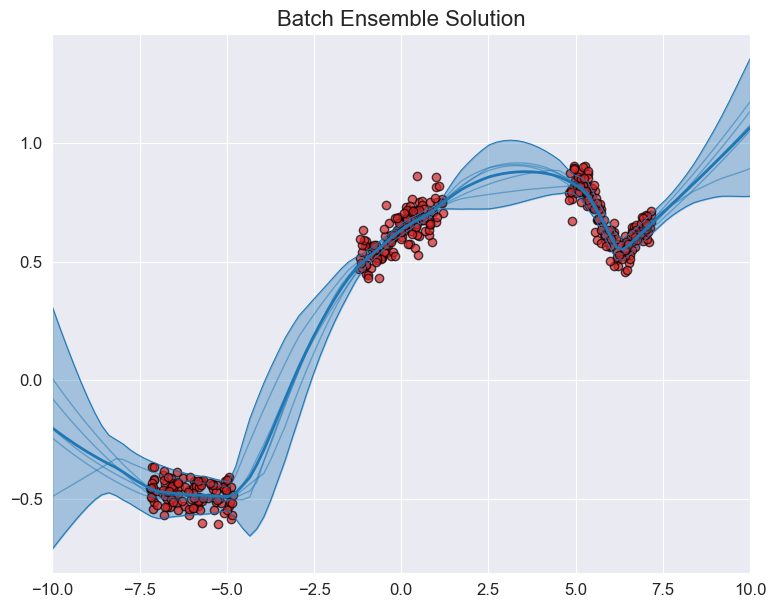

In [9]:
# Plot code from drbayes github
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32)).to(device)

trajectories = []
out = ShallowBatchEnsemble(inp.repeat(M,1)).cpu().detach().numpy().T

trajectories.append(out)
# trajeectories shape is (100*M) we need to reshape --> (M,100)
trajectories = np.vstack(trajectories).reshape(M,100)


plot_predictive(data, trajectories, z, title="Batch Ensemble Solution")